# Concept to predict (generate) p margin upon burnup core configuration

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..'))) # imports top level

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import display
import scipy

In [2]:

df = pd.read_excel("input.xlsx", sheet_name="no_burnup")

In [3]:
df.columns

Index(['Name', 'pmar', 'p, %', 'p, beff', '7-6_s', '7-5_s', '7-4_s', '7-3_s',
       '6-6_s', '6-5_s', '6-4_s', '6-3_s', '5-6_s', '5-3_s', '4-6_s', '4-3_s',
       '3-6_s', '3-5_s', '3-4_s', '3-3_s', '2-6_s', '2-5_s', '2-4_s', '2-3_s',
       '7-6_b', '7-5_b', '7-4_b', '7-3_b', '6-6_b', '6-5_b', '6-4_b', '6-3_b',
       '5-6_b', '5-3_b', '4-6_b', '4-3_b', '3-6_b', '3-5_b', '3-4_b', '3-3_b',
       '2-6_b', '2-5_b', '2-4_b', '2-3_b', '7-6_t', '7-5_t', '7-4_t', '7-3_t',
       '6-6_t', '6-5_t', '6-4_t', '6-3_t', '5-6_t', '5-3_t', '4-6_t', '4-3_t',
       '3-6_t', '3-5_t', '3-4_t', '3-3_t', '2-6_t', '2-5_t', '2-4_t', '2-3_t',
       'Temperature, K', 'p loss due to temperature, %', 'Notes'],
      dtype='object')

In [4]:
d = display.Display(df=df)
d.quick_processing()

The columns with prefix  are not in DataFrame


In [5]:
df = d.df

# Predicting p margin

In [66]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, Normalizer, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [6]:
df_p = df.loc[
    :, 
    [
        "p, %",
        *d.CORE_PARTS["left"]["ALL_CELLS"],
        "average_l",
    ]
]

In [7]:
df_p

,"p, %",7-6_l,7-5_l,7-4_l,7-3_l,6-6_l,6-5_l,6-4_l,6-3_l,5-6_l,...,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l,average_l
0,7.297184,300.00,155.79,193.2645,219.48,189.2100,201.2145,109.2860,245.5490,156.9595,...,195.27,196.0205,120.2835,196.1795,247.0330,155.460,289.17,116.04,201.93,197.747000
1,7.774369,152.94,128.01,257.1600,181.77,163.6905,165.1745,234.3925,206.1435,129.4525,...,300.00,170.6335,238.1820,161.2790,211.1785,165.254,250.74,130.35,171.60,189.847025
2,6.755688,300.00,128.01,257.1600,181.77,163.6905,165.1745,234.3925,206.1435,129.4525,...,152.94,170.6335,238.1820,161.2790,211.1785,165.254,250.74,130.35,171.60,189.847025
3,8.368326,151.65,126.66,255.0000,179.85,162.4185,163.3725,232.1135,204.1030,128.0480,...,296.49,169.3350,236.0885,159.3975,209.1910,163.982,248.79,128.94,169.89,194.207975
4,9.594128,151.65,255.00,300.0000,179.85,162.4185,163.3725,232.1135,204.1030,128.0480,...,296.49,169.3350,236.0885,159.3975,209.1910,163.982,128.94,248.79,169.89,202.874975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,7.108597,260.31,271.26,300.0000,175.77,177.0200,110.1870,195.1195,178.6100,156.3500,...,157.32,178.9545,201.5590,111.3795,182.3995,260.790,176.97,300.00,271.38,199.774950
178,8.861057,260.31,175.77,150.9600,271.26,177.0200,110.1870,195.1195,178.6100,156.3500,...,300.00,178.9545,201.5590,111.3795,182.3995,260.790,176.97,157.32,271.38,199.774950
179,9.426764,150.96,175.77,260.3100,271.26,177.0200,110.1870,178.6100,195.1195,156.3500,...,300.00,178.9545,182.3995,111.3795,201.5590,157.320,176.97,260.79,271.38,199.774950
180,3.601943,247.74,164.31,139.9800,254.34,166.6055,101.1505,180.0410,164.6710,145.6705,...,277.38,168.6460,188.0970,101.7070,168.7520,248.040,165.87,146.34,255.48,186.429025


In [38]:
y_p = df.loc[:, "p, %"]
X_raw_p = df_p.drop("p, %", axis=1)

In [39]:
ct_p = ColumnTransformer(
    [
        ("", StandardScaler(), X_raw_p.columns)
    ]
).set_output(transform="pandas")

In [40]:
X_p = ct_p.fit_transform(X_raw_p)

In [41]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

In [42]:
rfr = RandomForestRegressor()
ada = AdaBoostRegressor()

In [43]:
rfr.fit(X_train_p, y_train_p)
ada.fit(X_train_p, y_train_p)

AdaBoostRegressor()

In [44]:
y_rfr_p = rfr.predict(X_test_p)
y_ada_p = ada.predict(X_test_p)

In [45]:
rfr.score(X_test_p, y_test_p), ada.score(X_test_p, y_test_p)

(0.836456154640079, 0.8263885332238323)

In [46]:
mean_absolute_error(
    y_rfr_p, 
    y_test_p
), mean_absolute_error(
        y_ada_p, 
        y_test_p
)

(0.33727150674334844, 0.44259499569204064)

<Axes: xlabel='p, %', ylabel='p, %'>

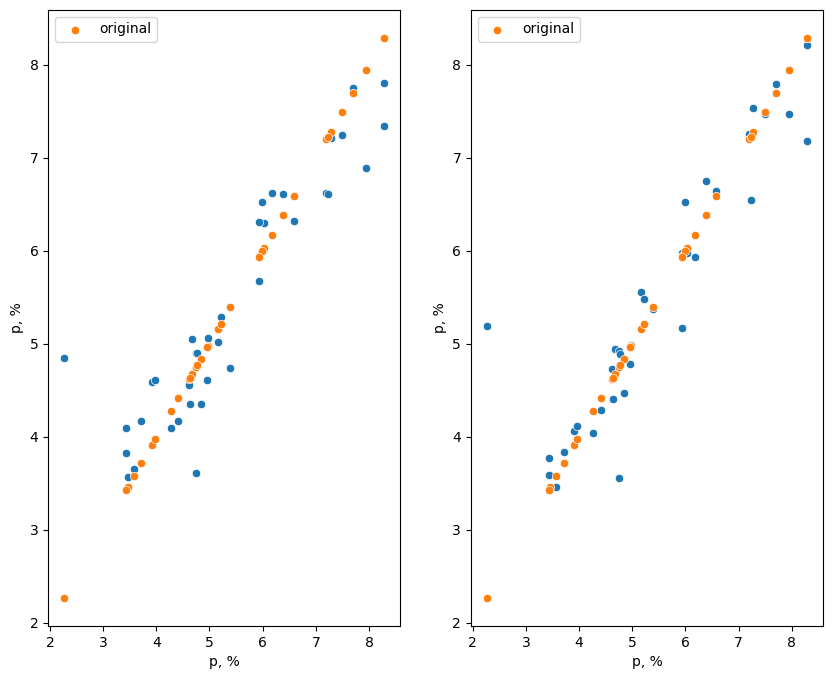

In [47]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
sns.scatterplot(x=y_test_p, y=y_ada_p, ax=axs[0])
sns.scatterplot(x=y_test_p, y=y_test_p, ax=axs[0], label="original")
sns.scatterplot(x=y_test_p, y=y_rfr_p, ax=axs[1])
sns.scatterplot(x=y_test_p, y=y_test_p, ax=axs[1], label="original")

In [54]:
X_train_raw_p, X_test_raw_p, y_train_p, y_test_p = train_test_split(X_raw_p, y_p, test_size=0.2, random_state=42)

In [67]:
pl = Pipeline(
    [
        ("", StandardScaler()),
        ("rfr", RandomForestRegressor())
    ]
)

In [68]:
pl.fit(X_train_raw_p, y_train_p)

Pipeline(steps=[('', StandardScaler()), ('rfr', RandomForestRegressor())])

In [70]:
mean_absolute_error(
    pl.predict(X_test_raw_p),
    y_test_p
)

0.31476502544461454

In [71]:
from joblib import dump, load
dump(filename="pmargin_v0.1.joblib", value=pl)

['pmargin_v0.1.joblib']

In [72]:
pmargin_model = load("pmargin_v0.1.joblib")

In [73]:
mean_absolute_error(
    pmargin_model.predict(X_test_raw_p),
    y_test_p
)

0.31476502544461454